In [12]:
# Hugging Face model "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
from transformers import pipeline

roberta_pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

roberta_pipe("Nvidia stock today jumps on price target boost") # Example financial news headline

Device set to use cpu


[{'label': 'positive', 'score': 0.9996346235275269}]

In [3]:
import requests
import holidays
from datetime import datetime, timedelta, timezone

API_KEY = 'YOUR_API_KEY' # Set up personal Finnhub API key before running the script
ticker = 'NVDA'          # Stock ticker
keywords = ["nvidia"]    # Key word to filter out headlines
headlines = []

us_holidays = holidays.US()
current_date = datetime.now(timezone.utc).date()
days_collected = 0
num_headlines = 35   # Collect 35 headlines
trading_days_needed = 7  # Over 7 trading days

while days_collected < trading_days_needed and len(headlines) < num_headlines:
    
    if current_date.weekday() >= 5 or current_date in us_holidays:  # Skip non-trading days (U.S holidays and weekends)
        current_date = current_date - timedelta(days=1)
        continue

    date_str = current_date.strftime('%Y-%m-%d')
    url = f'https://finnhub.io/api/v1/company-news?symbol={ticker}&from={date_str}&to={date_str}&token={API_KEY}'
    
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        for item in news_data:
            if 'headline' in item and any(kw in item['headline'].lower() for kw in keywords):
                if len(headlines) >= num_headlines:
                    break
                headlines.append(item['headline'])
        print(f"Fetched {len(headlines)} total headlines after {date_str}")
    else:
        print(f"Failed to fetch for {date_str}: {response.text}")

    current_date = current_date - timedelta(days=1)
    days_collected += 1

print(f"Final count: {len(headlines)} headlines from {days_collected} trading days.")

Fetched 12 total headlines after 2025-07-18
Fetched 24 total headlines after 2025-07-17
Fetched 35 total headlines after 2025-07-16
Final count: 35 headlines from 3 trading days.


In [4]:
from collections import Counter

# Count labels first
sentiment_counts = Counter()
label_confidences = []

for hl in headlines:
    result = roberta_pipe(hl)
    label = result[0]['label'].lower()
    confidence = result[0]['score']
    sentiment_counts[label] += 1
    label_confidences.append((label, confidence))

# Extract counts
pos = sentiment_counts['positive']
neg = sentiment_counts['negative']
neu = sentiment_counts['neutral']
total = len(headlines)

# Weighting logic for headlines
diff = pos - neg
margin = max(1, total * 0.05)  # Tolerance margin, 5% of headlines

# Baseline weights
positive_weight = 1.0
negative_weight = -1.0

# Positive / negative weights
if diff > margin:           # if there are more significantly more positive headlines
    positive_weight += 0.5  # positive tilt
elif diff < -margin:        # if there are more significantly more negative headlines
    negative_weight -= 0.5  # negative tilt

# Neutral weights
# If either positive or negative dominates, neutrals lean toward that side
if pos > neg + margin:
    neutral_penalty = 0.1  # neutrals lean slightly positive
elif neg > pos + margin:
    neutral_penalty = -0.1  # neutrals lean slightly negative
else:
    neutral_penalty = 0.0  # no weight

# Scoring function with weights
def map_label_to_weighted_score(label, confidence):
    if label == 'positive':
        return positive_weight * confidence
    elif label == 'negative':
        return negative_weight * confidence
    else:
        return neutral_penalty * confidence

# Apply scoring
total_score = 0
for label, confidence in label_confidences:
    total_score += map_label_to_weighted_score(label, confidence)

avg_score = total_score / total if total > 0 else 0

if avg_score > 0.2:
    overall_sentiment = "Positive"
elif avg_score < -0.2:
    overall_sentiment = "Negative"
else:
    overall_sentiment = "Neutral"

# Summary
print("\n=== Sentiment Analysis Summary ===")
print(f"Weighted Average Score: {avg_score:.3f} → Overall Sentiment: {overall_sentiment}")
print(f"Raw Sentiment Counts: {dict(sentiment_counts)}")
print(f"Scoring Weights Used → Positive: {positive_weight:.2f}, Negative: {negative_weight:.2f}, Neutral Contribution: {neutral_penalty}")


=== Sentiment Analysis Summary ===
Weighted Average Score: 0.478 → Overall Sentiment: Positive
Raw Sentiment Counts: {'positive': 14, 'neutral': 15, 'negative': 6}
Scoring Weights Used → Positive: 1.50, Negative: -1.00, Neutral Contribution: 0.1


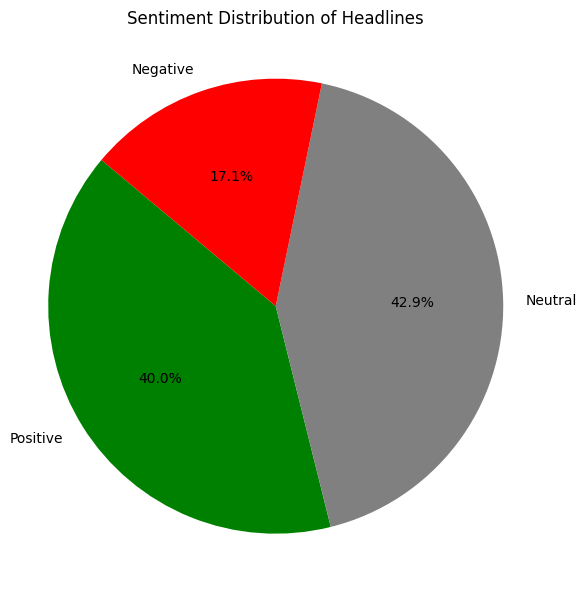

In [5]:
# Visualize with pie chart
import matplotlib.pyplot as plt
from collections import Counter

def plot_sentiment_distribution(headlines):
    sentiment_counts = Counter()

    for hl in headlines:
        result = roberta_pipe(hl)[0]
        sentiment_counts[result['label'].capitalize()] += 1

    if not sentiment_counts:
        print("No sentiment data to plot.")
        return

    labels = list(sentiment_counts.keys())
    sizes = list(sentiment_counts.values())
    colors = ['green', 'gray', 'red']  # You can map these to actual labels if needed

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors[:len(labels)], startangle=140)
    plt.title("Sentiment Distribution of Headlines")
    plt.axis('equal')  # Ensures the pie is round
    plt.tight_layout()
    plt.show()
    
plot_sentiment_distribution(headlines)

In [6]:
# Print out headlines for reference
headlines_with_label = {}

# Run sentiment model on each headline
for hl in headlines:
    result = roberta_pipe(hl)
    headlines_with_label[hl] = result

# Output each headline and sentiment score
for i, (headline, result) in enumerate(headlines_with_label.items(), 1):
    label = result[0]['label']
    score = result[0]['score']
    print(f"{i}. [{label.lower()} | {score:.3f}] {headline}")

1. [positive | 0.995] Alibaba Stock Retakes Key Level After Gains From Nvidia News
2. [neutral | 0.990] Nvidia Stock: How To Buy Shares In AI's Kingpin At A Discount
3. [negative | 0.992] Stock Market Hits Highs On Nvidia AI Chip News, Taiwan Semi Earnings, Economic Data: Weekly Review
4. [positive | 0.998] Nvidia CEO Huang Just Met With China’s Commerce Minister. Why the Stock Is Gaining.
5. [negative | 0.961] US and UAE Nvidia Deal Hits Security Roadblock
6. [negative | 0.644] Nvidia Rally Shows Signs of Overheating as Gains Blow Past 80%
7. [neutral | 1.000] Zacks Investment Ideas feature highlights: Microsoft, Nvidia, Alphabet, Arm Holdings and Advanced Micro Devices
8. [negative | 0.973] NVDA: Nvidia AI Boom Sparks Warning Bells as Pullback Risks Climb
9. [positive | 0.998] Nvidia Corp. (NVDA) Climbed Back from its Declines in Q2
10. [positive | 0.998] Analyst Says NVIDIA (NVDA) Will See Rising Competition in Future – ‘There’s Going to Be Other Solutions’
11. [neutral | 1.000] NVD